<a href="https://colab.research.google.com/github/dac1997/MuonLifetimeExperience/blob/main/Exp_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of an exponential signal for the muon lifetime experiment

In [ ]:
import ROOT

In [ ]:
# Diego Alberto Coloma Borja, 2023
#python 3

#import libraries
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as spicy
from scipy import stats
from scipy.optimize import curve_fit
from IPython.display import clear_output

%matplotlib inline

### Definition of the functions that are used to create the simulation and analyze the results given

In [ ]:
def exp_function(x, a, tau):
    return a*np.exp(-x/tau)

def simulation_fitting(numberofentries=100000, tau_long=187, tau_short=75, create_pictures="no"):

    uniform=np.array([random() for j in range(numberofentries)])
    array=-tau_long*np.log(1-uniform)

    counts, bines , _ = plt.hist(array,bins=np.linspace(0,2048,2049),
                             histtype= 'step', label="simulated signal")

    bin_centers    = (bines[:-1] + bines[1:])/2

    fits_taus,fits_aplus,tau_errors, pulls  = [],[],[],[]
    cutters = [0,5,6,7,8]

    for i in cutters:
      cut = i*tau_short
      x   = bin_centers[cut:]
      y   = counts[cut:]

      fitting,cov = curve_fit(exp_function, x, y, p0=(numberofentries/200, tau_long))
      theory      = exp_function(x,fitting[0],fitting[1])
      #error       = np.sqrt(np.sum((np.array()-theory)**2)/len(y))
      error       = np.sqrt(cov[0][0])
      stat        = (fitting[1] - tau_long)/error

      if create_pictures =='yes':
        plt.plot(x,theory, linewidth=4,
                 label ="tau = %f" %fitting[1])
      fits_taus.append(fitting[1])
      fits_aplus.append(fitting[0])
      tau_errors.append(error)
      pulls.append(stat)


    if create_pictures=="yes":
      plt.legend(fontsize=12)
      plt.show()

    baselines=[]
    for i in cutters[1:]:
      baselines.append(np.mean(counts[i*tau_long:]))

    plt.close()

    return fits_taus, fits_aplus, tau_errors, pulls, baselines


def pull_sim_statistics(n_sims, numberofentries=10000, verbose="yes"):

    col_names  = ["tau_full", "tau_5s", "tau_6s","tau_7s", "tau_8s",
                  "err_full","err_5s","err_6s","err_7s","err_8s",
                  "spr_full","spr_5s","spr_6s","spr_7s","spr_8s",
                  "base_5l","base_6l","base_7l","base_8l",
                  "amp_full","amp_5s","amp_6s","amp_7s","amp_8s"]
    rows=[]
    for i in range(n_sims):
        if verbose == "yes":
            print("Running sim #", i+1)
        taus, aplus, errors, spread, baselines = simulation_fitting(numberofentries)
        clear_output(wait='True')

        rows.append(taus + errors + spread + baselines + aplus)
    df=pd.DataFrame(rows, columns=col_names)

    return df

## Example of the running of one signal simulation

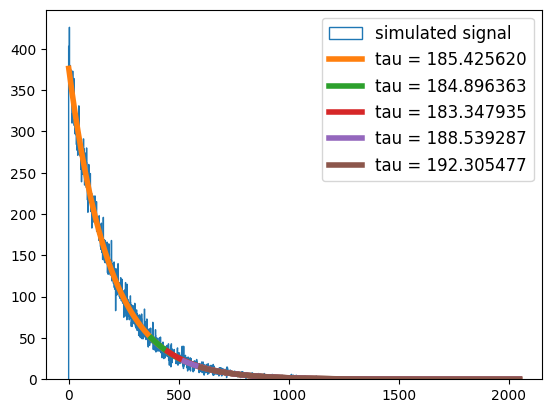

[185.425619527158, 184.8963634739246, 183.34793485555602, 188.53928694709091, 192.30547746533742] [0.8821000683313509, 10.020539843741995, 15.319978525218694, 17.54796114482447, 22.56015214678399]


In [ ]:
a,b,c,d,e = simulation_fitting(70000,create_pictures="yes")
print(a,c)
#extra output: baseline from exponential 5 taus 6 tau 7 tau

## Example running the many simulations

In [ ]:
stats_exp_week  = pull_sim_statistics(1000,70000,"yes")
print(stats_exp_week)

## Now running the pull_sim_statistics that run the given number of simulations

#### Remember if you want to know how the simulation is coming along as it is running to change the verbose to "yes" before running

In [ ]:
entriesperminute   = 31745/(3*86400)
week = entriesperminute*86400*7

In [ ]:
#Obtains: the statistics for weeks of counts
stats_exp_week  = pull_sim_statistics(1000, int(week),"yes")
stats_exp_3week  = pull_sim_statistics(1000, int(3*week),"yes")
stats_exp_5week = pull_sim_statistics(1000, int(5*week), "yes")
# outputs the information to a csv file
stats_exp_week.to_csv("stats_exp_week.csv")
stats_exp_3week.to_csv("stats_exp_3week.csv")
stats_exp_5week.to_csv("stats_exp_5week.csv")

Running sim # 1000


## 1000 Simulation Histogram
Plot Histograms of the spread of the dataframe values change first dataframe and guesser according to change which simulation is used

In [ ]:
def gauss_fitti(binning, counts, initial_guess):
    bin_mids = (binning[:-1] + binning[1:])/2.
    parameters, _ = curve_fit(pana_gauss, bin_mids, counts, p0=initial_guess)
    media = parameters[0]
    desvi = parameters[1]

    return media,desvi

def pana_gauss(x, u , sigma):
    '''function that defines the gauss function to fit parameters
       u     - mean of the function
       sigma - standard deviation
       x.    -      input'''

    c = np.sqrt(2 * np.pi)
    return np.exp(-0.5 * ((x-u)/ sigma)**2) / sigma / c

In [ ]:
def plotter(dataf, naming="gen", create_figures="yes"):
  tau_columnns = dataf.columns.values.tolist()

  timel_vals   = []
  for cut in tau_columnns[0:5]:
    time, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                            histtype="step")
    gauss_t,_ = gauss_fitti(bines,time,(180,10))
    timel_vals.append(gauss_t)

  plt.title("LifeTime from Simulation for a %s period" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(tau_columnns[0:5], timel_vals)])
  if create_figures=="yes":
    plt.show()
  plt.savefig("Exp_Lifetime_%s.png" %(naming))
  plt.close()

  err_vals=[]
  for cut in tau_columnns[5:10]:
    errors, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                               histtype="step")
    gauss_e,_ = gauss_fitti(bines,errors,(10,5))
    err_vals.append(gauss_e)

  plt.title("Lifetime Errors from Simulation for a %s period" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(tau_columnns[5:10], err_vals)])
  if create_figures=="yes":
    plt.show()
  plt.savefig("Exp_LifetimeError_%s.png" %(naming))
  plt.close()

  pull_vals=[]
  std_chk  =[]
  for cut in tau_columnns[10:15]:
    pulles, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                               histtype="step")
    gauss_p,std = gauss_fitti(bines,pulles,(0,1))
    pull_vals.append(gauss_p)
    std_chk.append(std)

  plt.title("Lifetime Pulls from Simulation for a %s period" %naming)
  plt.legend(["%s : %.3f +- %.2f" %(i,j,k) for i,j,k in zip(tau_columnns[10:15], pull_vals,std_chk)])
  if create_figures=="yes":
    plt.show()
  plt.savefig("Exp_LifetimePull_%s.png" %(naming))
  plt.close()

  base_vals=[]
  for cut in tau_columnns[15:19]:
    basex, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                               histtype="step")
    gauss_b,_ = gauss_fitti(bines,basex,(0,1))
    base_vals.append(gauss_b)

  plt.title("Extracted Baselines from Simulation for a %s period" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(tau_columnns[15:19], base_vals)])
  if create_figures=="yes":
    plt.show()
  plt.savefig("Exp_LifetimeBases_%s.png" %(naming))
  plt.close()

  return timel_vals, err_vals, pull_vals, base_vals

In [ ]:
time,error,pull,basel = plotter(stats_exp_week, "week","no")
printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(time, error) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)
print("Baseline for simulated week of data taking at different cuts")
for bases in basel:
  print("Baseline Mean      : %.5f"%bases)

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01458 +/- 0.87596
Tau long estimation: 187.02714 +/- 9.52802
Tau long estimation: 187.08830 +/- 13.71588
Tau long estimation: 187.42621 +/- 19.23757
Tau long estimation: 187.53222 +/- 26.86024
Baseline for simulated week of data taking at different cuts
Baseline Mean      : 0.44778
Baseline Mean      : 0.19723
Baseline Mean      : 0.08946
Baseline Mean      : 0.04223


In [ ]:
time,error,pull,basel = plotter(stats_exp_5week, "3week","no")
printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(time, error) ]
print("Values for simulated 3 week of data taking at different cuts")
for i in printer:
  print(i)
print("Baseline for simulated 3 week of data taking at different cuts")
for bases in basel:
  print("Baseline Mean      : %.5f"%bases)

Values for simulated 3 week of data taking at different cuts
Tau long estimation: 187.02350 +/- 1.96019
Tau long estimation: 186.94152 +/- 21.35428
Tau long estimation: 186.99313 +/- 30.76336
Tau long estimation: 187.14175 +/- 43.65907
Tau long estimation: 187.04559 +/- 10.00000
Baseline for simulated 3 week of data taking at different cuts
Baseline Mean      : 2.23666
Baseline Mean      : 0.98452
Baseline Mean      : 0.44941
Baseline Mean      : 0.21353


time used: 11.31373143196106
